In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [214]:
archivos = ["weatherAUS", "titanic_test", "gender_submission"]

In [4]:
def Leer_Datos(filename, sp ='\t'):
    data = pd.read_csv(filename+".csv", sep = sp)
    return np.array(data.iloc[:,:])

In [161]:
def Normalizar_Datos(datos):
    for i in range (datos.shape[1]):
        media = np.mean(datos[:,i])       
        desvi =np.std(datos[:,i])
        datos[:,i] = (datos[:,i] - media)/desvi
    return datos

In [6]:
def Sigmoidal(X, theta):
    aux = X.dot(theta.T)
    return 1/(1+ np.exp(-aux))

In [7]:
def Calcular_Funcion_Costo(X, y, theta): #J(theta) = -1/m[ SUM( y* log(h(x)) + (1-y)*log(1-h(x)))
    h = Sigmoidal(X, theta)
    return -1/X.shape[0] * ( np.sum( y.dot(np.log(h)) + (1-y).dot( np.log(1-h))) )

In [8]:
def Calcular_Gradiente(X, y, theta): #deriv = 1/m[ SUM (h(x)-y)x ]
    h = Sigmoidal(X, theta) - y
    return np.dot(h, X) / X.shape[0]

In [9]:
def Gradiente_Descendiente(X, y, theta, num_it, tasa_apren):
    costos = np.zeros(num_it)
    for it in range(0, num_it):
        costos[it] = Calcular_Funcion_Costo(X, y, theta)
        theta = theta - (tasa_apren* Calcular_Gradiente(X, y, theta))
    return theta, costos

In [194]:
def Calcular_Accuracy(X, y, theta):
    htxP = Sigmoidal(X, theta) > 0.5
    n_1s = np.logical_xor(np.logical_not(htxP), y)
    return np.sum(n_1s) / y.shape[0]

In [195]:
def PromedioAccuracy(test, theta, k):
    accu = np.zeros(k)
    for i in range(0,k):
        accu[i] = Calcular_Accuracy(test[i][:,:-1], test[i][:,-1], theta)
    return accu.mean()

In [76]:
def Crear_k_folds(data, k):
    folds = []
    num_1 = np.count_nonzero(data[:,-1]) #numero clase 1
    num_0 = data.shape[0] - num_1 #numero clase 0
    new_num_1 = int(num_1/k) #Para conservar proporcion
    new_num_0 = int(num_0/k)
    print("0: " , new_num_0)
    print("1: " , new_num_1)
    fold0 = np.array_split(data[0:num_0], k)
    fold1 = np.array_split(data[num_0:], k)
    #print (fold0)
    for i in range (0,k):
        folds.append(np.vstack((fold0[i],fold1[i])))
    return folds

# Experiemto 1

In [177]:
#Leer solo los datos necesarios
weatherAUS = Leer_Datos(archivos[0],',')
aux = np.c_[weatherAUS[:,2:3], weatherAUS[:,3:4],weatherAUS[:,-3:-2],weatherAUS[:,-1:]]

#quitamos los datos nulos
aux = pd.DataFrame(aux).dropna()

#dividimos para normalizar y normalizamos
aux1 = aux.to_numpy()[:,:2]
aux2 = aux.to_numpy()[:,-2:]

aux1 = Normalizar_Datos(aux1)

#reemplazamos yes/no por 1/0
aux2 = pd.DataFrame(aux2).replace({"No": 0, "Yes": 1})

#juntamos la data
weatherAUS = np.array(np.c_[aux1,aux2], dtype = "float64")

#creamos los folks
fold_weatherAUS = Crear_k_folds(weatherAUS, 3)

0:  36344
1:  10351


In [229]:
#Leer solo los datos necesarios
titanic = Leer_Datos(archivos[1],',')
gender = Leer_Datos(archivos[2],',')
aux = np.c_[titanic[:,3:4], titanic[:,4:5],titanic[:,-3:-2],gender[:,-1:]]

#quitamos los datos nulos
aux = pd.DataFrame(aux).dropna()

#dividimos para normalizar y normalizamos
aux1 = aux.to_numpy()[:,0:1]
aux2 = aux.to_numpy()[:,1:3]
aux3 = aux.to_numpy()[:,-1:]

aux2 = Normalizar_Datos(aux2)

#reemplazamos female/male por 1/0
aux1 = pd.DataFrame(aux1).replace({"male": 0, "female": 1})

#juntamos la data
titanic = np.array(np.c_[aux1,aux2,aux3], dtype = "float64")

#creamos los folks
fold_titanic = Crear_k_folds(titanic, 3)

0:  68
1:  42


In [170]:
def CalculoParametros(folds:[], k:int, iteraciones, alpha):
    arr_costo = []
    arr_theta = []
    arr_test = []
    for test_i in range(0, k):
        test = folds[test_i] 
        train = np.zeros( (0,np.size(folds[0][0])) )
        for train_i in range (0, k):         
            if (train_i == test_i):
                continue
            else:
                train = np.vstack( (train,folds[train_i]) )
            
        costo = []
        X_train = train[:,:-1]
        y_train = train[:,-1]
        theta = np.zeros( (np.size(X_train[0])) )
    #s = Sigmoidal(X_train, theta)
    #c = Calcular_Funcion_Costo(X_train, y_train, theta)
        theta, costo = Gradiente_Descendiente(X_train, y_train, theta, iteraciones, alpha)
        arr_theta.append(theta)
        arr_costo.append(costo)
        arr_test.append(test)
      
    return theta, arr_costo, arr_test

In [171]:
def BusquedaParametros(folds:[], k):
    alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
    iteraciones = range(500,3501,500)
    arr_accu = np.empty( (len(alpha),len(iteraciones) ))
    for tasa in range(0,len(alpha)):
        for it in range(0, len(iteraciones)):
            theta, dummy, test = CalculoParametros(folds, k, iteraciones[it], alpha[tasa])
            arr_accu[tasa,it] = PromedioAccuracy(test, theta, k)
            
    return pd.DataFrame(arr_accu, index = alpha, columns = iteraciones)

In [193]:
BusquedaParametros(fold_weatherAUS, 3)

,500,1000,1500,2000,2500,3000,3500
0.01,0.589709,0.601245,0.606627,0.609026,0.611032,0.611824,0.612959
0.05,0.611039,0.614729,0.615829,0.615657,0.615650,0.615807,0.615779
0.10,0.614708,0.615657,0.615807,0.615800,0.615772,0.615814,0.615772
0.20,0.615672,0.615800,0.615814,0.615772,0.615772,0.615772,0.615772
0.30,0.615807,0.615814,0.615772,0.615772,0.615772,0.615772,0.615772
0.40,0.615800,0.615772,0.615772,0.615772,0.615772,0.615772,0.615772


In [230]:
BusquedaParametros(fold_titanic, 3)

,500,1000,1500,2000,2500,3000,3500
0.01,0.873109,0.870106,0.870106,0.870106,0.873137,0.873137,0.876140
0.05,0.873137,0.879170,0.879170,0.873109,0.873109,0.873109,0.873109
0.10,0.879170,0.873109,0.873109,0.873109,0.873109,0.873109,0.873109
0.20,0.873109,0.873109,0.873109,0.873109,0.873109,0.873109,0.873109
0.30,0.873109,0.873109,0.873109,0.873109,0.873109,0.873109,0.873109
0.40,0.873109,0.873109,0.873109,0.873109,0.873109,0.873109,0.873109


# Experimento 2

In [231]:
costo_weatherAUS = CalculoParametros(fold_weatherAUS, 3, 2500, 0.20)[1]
costo_titanic = CalculoParametros(fold_titanic, 3, 1000, 0.10)[1]

In [205]:
def PloteoCurvaCosto (arr, title):       
    fig, ax = plt.subplots()
    #Ploteo de Curva
    scale = 1.0
    color = 'tab:blue'
    iteraciones = len(arr)
    plt.plot(range(0,iteraciones), arr, 'o', linewidth=1, markersize=2 )

    plt.title(title, {'fontsize':10})
    ax.set(xlim = [-10,iteraciones], ylim = (arr[-1]-0.1,arr[0]))
    ax.grid(True)
    plt.xlabel('Iteración')
    plt.ylabel('Costo')
    plt.show()

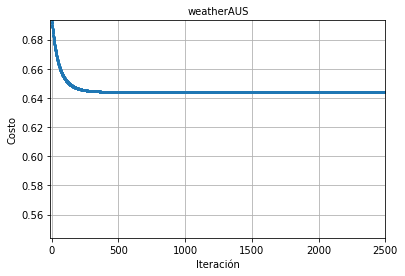

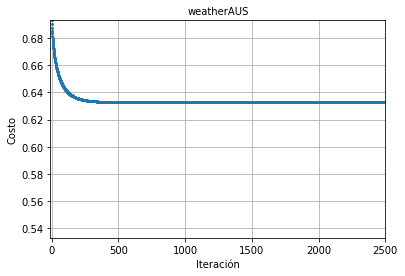

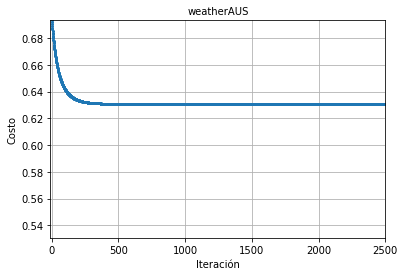

In [232]:
PloteoCurvaCosto(costo_weatherAUS[0], "weatherAUS")
PloteoCurvaCosto(costo_weatherAUS[1], "weatherAUS")
PloteoCurvaCosto(costo_weatherAUS[2], "weatherAUS")

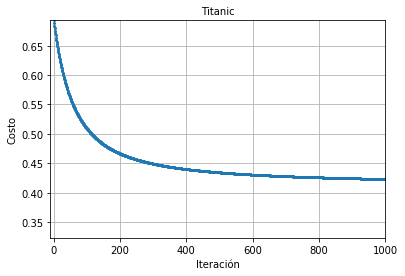

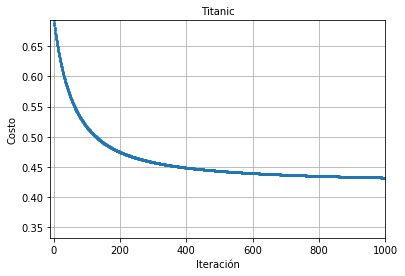

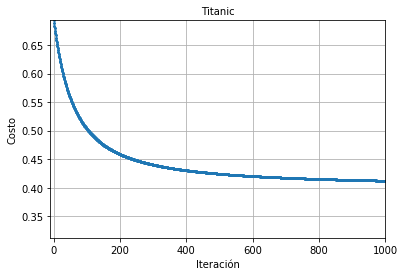

In [233]:
PloteoCurvaCosto(costo_titanic[0], "Titanic")
PloteoCurvaCosto(costo_titanic[1], "Titanic")
PloteoCurvaCosto(costo_titanic[2], "Titanic")

# Experimento 3